# Throughput Benchmark Plotter (SPS vs Num Envs)

Load one or more JSON result files from `benchmarks/results/` or elsewhere and plot Steps Per Second (SPS) vs number of environments.

In [1]:
from __future__ import annotations

import json
from collections import defaultdict
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter, FuncFormatter, ScalarFormatter
from pyprojroot import here

# Configure default directory to look for results
DEFAULT_RESULTS_DIR = here('benchmarks/results')

In [2]:
def load_json(p: Path) -> dict[str, Any]:
    with p.open('r') as f:
        return json.load(f)


def load_results(paths: list[Path]) -> list[dict[str, Any]]:
    return [load_json(p) for p in paths]


def guess_result_files(dir_path: Path = DEFAULT_RESULTS_DIR) -> list[Path]:
    if not dir_path.exists():
        return []
    return sorted(dir_path.glob('*.json'))


def normalize_records(run: dict[str, Any], source: Path) -> list[dict[str, Any]]:
    """Flatten a run JSON into per-(mode,num_envs) records.

    Handles:
    - New flat format: {meta: {..., mode}, throughput: { num_envs: { ... } } }
    - Old nested format: {meta: {..., mode}, throughput: { num_envs: { mode: { ... } } } }
    - Legacy multi-mode format
    """
    meta = run.get('meta', {})
    run_tag = meta.get('run_tag', '')
    ts = meta.get('timestamp', '')
    system = meta.get('system', {})
    mode_in_meta = meta.get('mode')  # new per-mode files

    records: list[dict[str, Any]] = []
    thr = run.get('throughput', {})

    # --- New flat format: { num_envs: { ... } } with mode in meta ---
    if (
        isinstance(thr, dict)
        and thr
        and all(isinstance(v, dict) and not any(k in v for k in ('arcle-sync','arcle-async','jaxarc-jit','jaxarc-pmap','JaxARC','ARCLE')) for v in thr.values())
        and mode_in_meta
    ):
        for num_envs_str, payload in thr.items():
            try:
                num_envs = int(num_envs_str)
            except Exception:
                num_envs = num_envs_str
            sps = payload.get('sps', []) or []
            times = payload.get('times', []) or []
            records.append({
                'num_envs': num_envs,
                'mode': mode_in_meta,
                'sps': sps,
                'times': times,
                'run_tag': run_tag,
                'timestamp': ts,
                'system': system,
                'source': str(source),
            })
        return records

    # --- Old nested format: { num_envs: { mode: { ... } } } ---
    if isinstance(thr, dict) and thr and any(isinstance(v, dict) for v in thr.values()):
        for num_envs_str, per_mode in thr.items():
            try:
                num_envs = int(num_envs_str)
            except Exception:
                num_envs = num_envs_str
            if isinstance(per_mode, dict):
                for mode_name, payload in per_mode.items():
                    sps = payload.get('sps', []) or []
                    times = payload.get('times', []) or []
                    records.append({
                        'num_envs': num_envs,
                        'mode': mode_name,
                        'sps': sps,
                        'times': times,
                        'run_tag': run_tag,
                        'timestamp': ts,
                        'system': system,
                        'source': str(source),
                    })
        return records

    # --- Legacy fallback: try to detect flat keys 'JaxARC'/'ARCLE' ---
    if isinstance(thr, dict):
        for num_envs_str, payload in thr.items():
            try:
                num_envs = int(num_envs_str)
            except Exception:
                num_envs = num_envs_str
            for mode_name in ('JaxARC', 'ARCLE'):
                if mode_name in payload:
                    item = payload[mode_name]
                    records.append({
                        'num_envs': num_envs,
                        'mode': mode_name,
                        'sps': item.get('sps', []) or [],
                        'times': item.get('times', []) or [],
                        'run_tag': run_tag,
                        'timestamp': ts,
                        'system': system,
                        'source': str(source),
                    })
    # If meta has a single mode, attach it
    if mode_in_meta and not any(r.get('mode') for r in records):
        for r in records:
            r['mode'] = mode_in_meta
    return records


# Example: auto-discover JSONs; you can override by providing explicit paths in the next cell.
auto_files = guess_result_files()
auto_files

[PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-async_20250915-173558.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250915-173558.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_jaxarc-jit_20250916-091636.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_arcle-async_20250915-153352.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_arcle-sync_20250915-152434.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_jaxarc-jit_20250915-152014.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_jaxarc-pmap_20250915-145505.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_rtx_arcle-async_20250915-194327.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arc

In [3]:
# Manually specify files if desired, else use auto_files
files = auto_files  # e.g., [Path('benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250911-173456.json')]
files

[PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-async_20250915-173558.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250915-173558.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_jaxarc-jit_20250916-091636.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_arcle-async_20250915-153352.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_arcle-sync_20250915-152434.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_jaxarc-jit_20250915-152014.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_h100_jaxarc-pmap_20250915-145505.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_rtx_arcle-async_20250915-194327.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arc

In [4]:
# Load and normalize data for plotting
runs = [load_json(p) for p in files]
records = []
for p, run in zip(files, runs):
    records.extend(normalize_records(run, p))
len(records)

188

In [5]:
# Build filtering and aggregation utilities
from dataclasses import dataclass


@dataclass
class Filters:
    run_tag_contains: list[str]
    modes: list[str]


def filter_records(records: list[dict[str, Any]], flt: Filters) -> list[dict[str, Any]]:
    def ok(r: dict[str, Any]) -> bool:
        tag = (r.get('run_tag') or '').lower()
        if flt.run_tag_contains:
            if not any(s.lower() in tag for s in flt.run_tag_contains):
                return False
        if flt.modes:
            if r.get('mode') not in flt.modes:
                return False
        return True
    return [r for r in records if ok(r)]


def aggregate(records: list[dict[str, Any]]):
    # Group by (mode, run_tag, num_envs) and compute mean/std over SPS lists
    grouped: dict[tuple, list[float]] = defaultdict(list)
    for r in records:
        key = (r.get('mode'), r.get('run_tag'), r.get('num_envs'))
        # Each record's sps is a list across repeats; extend into the group
        for v in (r.get('sps') or []):
            grouped[key].append(v)
    # Compute summary
    summary = []
    for (mode, tag, num_envs), vals in grouped.items():
        if len(vals) == 0:
            continue
        arr = np.array(vals, dtype=float)
        summary.append({
            'mode': mode,
            'run_tag': tag,
            'num_envs': num_envs,
            'sps_mean': float(np.mean(arr)),
            'sps_std': float(np.std(arr)),
            'count': int(arr.size),
        })
    # Sort
    summary.sort(key=lambda x: (x['mode'], x['run_tag'], x['num_envs']))
    return summary

summary = aggregate(records)
len(summary)

183

In [6]:
# Parameters: choose filters and axes
# - run_tag_contains: list of substrings to match within run_tag; empty = no filter
# - modes: choose among ['arcle-sync','arcle-async','jaxarc-jit','jaxarc-pmap'] (empty = all)
# - yscale: 'linear' (default), 'log', or 'symlog'
# - yformat: 'eng' (SI units), 'comma', or 'sci'
run_tag_contains = []  # e.g., ['cpu', 'h100']
modes_filter = ['arcle-async']      # e.g., ['arcle-sync', 'arcle-async']
yscale = 'linear'      # 'linear' | 'log' | 'symlog'
yformat = 'eng'        # 'eng' | 'comma' | 'sci'

flt = Filters(run_tag_contains=run_tag_contains, modes=modes_filter)
filtered = filter_records(records, flt)
filtered_summary = aggregate(filtered)
len(filtered_summary)

37

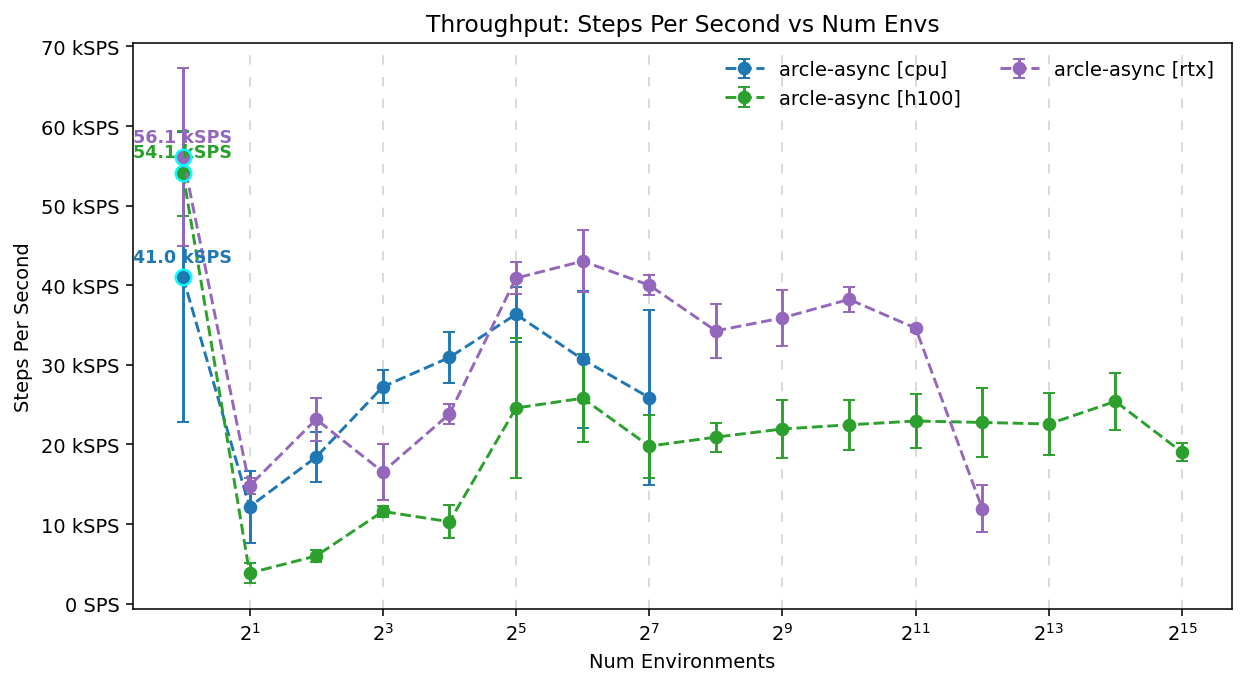

In [7]:
# Plot SPS vs num_envs for filtered data with clearer y-axis
if not filtered_summary:
    print('No data after filters. Adjust run_tag_contains or modes_filter.')
else:
    # Organize by (mode, run_tag)
    by_group: dict[tuple, list[dict[str, Any]]] = defaultdict(list)
    for row in filtered_summary:
        by_group[(row['mode'], row['run_tag'])].append(row)

    fig, ax = plt.subplots(figsize=(9, 5), dpi=140)
    for (mode, tag), rows in by_group.items():
        rows.sort(key=lambda x: x['num_envs'])
        xs = [r['num_envs'] for r in rows]
        ys = [r['sps_mean'] for r in rows]
        yerr = [r['sps_std'] for r in rows]
        label = f"{mode} [{tag or 'untagged'}]"
        style = '-' if 'jaxarc' in (mode or '') else '--'
        marker = 's' if 'jaxarc' in (mode or '') else 'o'
        container = ax.errorbar(xs, ys, yerr=yerr, marker=marker, linestyle=style, label=label, capsize=3)

        # Annotate the maximum point for this line with matching color and y-format
        if ys:
            try:
                idx_max = int(np.nanargmax(ys))
                x_max = xs[idx_max]
                y_max = ys[idx_max]

                # Choose a formatter consistent with yformat
                def _format_y(val: float) -> str:
                    if yformat == 'eng':
                        return EngFormatter(unit='SPS', places=1)(val)
                    elif yformat == 'comma':
                        return f"{val:,.0f}"
                    elif yformat == 'sci':
                        return f"{val:.2e}"
                    else:
                        return f"{val:.3g}"

                # Get the line color from the plotted container
                try:
                    line_color = container.lines[0].get_color()
                except Exception:
                    line_color = None

                # Draw a small highlight marker to indicate which point this label refers to
                ax.plot([x_max], [y_max],
                        marker='o', markersize=8,
                        markerfacecolor='none', markeredgecolor='cyan', markeredgewidth=1.2,
                        linestyle='None', zorder=5)

                ax.annotate(
                    _format_y(y_max),
                    (x_max, y_max),
                    xytext=(0, 6),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    color=line_color,
                    fontsize=9,
                    fontweight='bold',
                    clip_on=True,
                )
            except Exception:
                pass

    ax.set_title('Throughput: Steps Per Second vs Num Envs')
    ax.set_xlabel('Num Environments')
    ax.set_ylabel('Steps Per Second')
    ax.set_xscale('log', base=2)

    # Configure y-scale
    if yscale in ('linear', 'log', 'symlog'):
        ax.set_yscale(yscale)

    # Configure y-axis formatting
    if yformat == 'eng':
        ax.yaxis.set_major_formatter(EngFormatter(unit='SPS'))
    elif yformat == 'comma':
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
    elif yformat == 'sci':
        sf = ScalarFormatter(useMathText=True)
        sf.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(sf)

    ax.grid(which='both', axis='x', linestyle=(0, (6, 8)), alpha=0.6)
    ax.legend(loc='best', ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()

## Calculate Speedups

Compute the maximum mean SPS achieved by JaxARC vs ARCLE on each platform.

In [8]:
def calculate_speedups():
    """Calculate max mean SPS for JaxARC vs ARCLE on each platform."""
    
    # Map of platform tags to display names
    platform_map = {
        'cpu': 'CPU (M2 Pro)',
        'rtx': 'RTX 3090',
        'h100': 'H100 GPU'
    }
    
    results = {}
    
    for platform_tag, platform_name in platform_map.items():
        # Filter records for this platform
        platform_records = [r for r in records if platform_tag in (r.get('run_tag') or '').lower()]
        
        if not platform_records:
            print(f"No data found for {platform_name}")
            continue
            
        # Separate JaxARC and ARCLE
        jaxarc_records = [r for r in platform_records if 'jaxarc' in (r.get('mode') or '').lower()]
        arcle_records = [r for r in platform_records if 'arcle' in (r.get('mode') or '').lower()]
        
        # Find max mean SPS for each
        jaxarc_max_sps = 0
        jaxarc_best_config = None
        for r in jaxarc_records:
            sps_values = r.get('sps', [])
            if sps_values:
                mean_sps = np.mean(sps_values)
                if mean_sps > jaxarc_max_sps:
                    jaxarc_max_sps = mean_sps
                    jaxarc_best_config = (r.get('mode'), r.get('num_envs'))
        
        arcle_max_sps = 0
        arcle_best_config = None
        for r in arcle_records:
            sps_values = r.get('sps', [])
            if sps_values:
                mean_sps = np.mean(sps_values)
                if mean_sps > arcle_max_sps:
                    arcle_max_sps = mean_sps
                    arcle_best_config = (r.get('mode'), r.get('num_envs'))
        
        if jaxarc_max_sps > 0 and arcle_max_sps > 0:
            speedup = jaxarc_max_sps / arcle_max_sps
            results[platform_name] = {
                'jaxarc_sps': jaxarc_max_sps,
                'jaxarc_config': jaxarc_best_config,
                'arcle_sps': arcle_max_sps,
                'arcle_config': arcle_best_config,
                'speedup': speedup
            }
            
            print(f"\n{platform_name}:")
            print(f"  JaxARC best: {jaxarc_max_sps:,.0f} SPS (mode={jaxarc_best_config[0]}, envs={jaxarc_best_config[1]})")
            print(f"  ARCLE best:  {arcle_max_sps:,.0f} SPS (mode={arcle_best_config[0]}, envs={arcle_best_config[1]})")
            print(f"  Speedup:     {speedup:.1f}×")
    
    return results

speedup_results = calculate_speedups()


CPU (M2 Pro):
  JaxARC best: 905,334 SPS (mode=jaxarc-jit, envs=524288)
  ARCLE best:  65,871 SPS (mode=arcle-sync, envs=256)
  Speedup:     13.7×

RTX 3090:
  JaxARC best: 36,570,507 SPS (mode=jaxarc-jit, envs=65536)
  ARCLE best:  68,011 SPS (mode=arcle-sync, envs=512)
  Speedup:     537.7×

H100 GPU:
  JaxARC best: 790,412,017 SPS (mode=jaxarc-pmap, envs=2097152)
  ARCLE best:  54,082 SPS (mode=arcle-async, envs=1)
  Speedup:     14615.0×


## One-to-One Speedup Comparison

Calculate speedup at matching batch sizes where both JaxARC and ARCLE have data.


In [10]:
import pandas as pd
from IPython.display import display, Markdown

def calculate_speedups_matched():
    """Calculate speedup at matching batch sizes where both frameworks have data."""
    
    # Map of platform tags to display names
    platform_map = {
        'cpu': 'CPU (M2 Pro)',
        'rtx': 'RTX 3090',
        'h100': 'H100 GPU'
    }
    
    results = {}
    
    for platform_tag, platform_name in platform_map.items():
        # Filter records for this platform
        platform_records = [r for r in records if platform_tag in (r.get('run_tag') or '').lower()]
        
        if not platform_records:
            print(f"No data found for {platform_name}")
            continue
            
        # Separate JaxARC and ARCLE, group by batch size
        jaxarc_by_batch = {}
        arcle_by_batch = {}
        
        for r in platform_records:
            num_envs = r.get('num_envs')
            mode = (r.get('mode') or '').lower()
            sps_values = r.get('sps', [])
            
            if not sps_values:
                continue
                
            mean_sps = np.mean(sps_values)
            
            if 'jaxarc' in mode:
                if num_envs not in jaxarc_by_batch or mean_sps > jaxarc_by_batch[num_envs]['sps']:
                    jaxarc_by_batch[num_envs] = {
                        'sps': mean_sps,
                        'mode': r.get('mode')
                    }
            elif 'arcle' in mode:
                if num_envs not in arcle_by_batch or mean_sps > arcle_by_batch[num_envs]['sps']:
                    arcle_by_batch[num_envs] = {
                        'sps': mean_sps,
                        'mode': r.get('mode')
                    }
        
        # Find common batch sizes
        common_batches = set(jaxarc_by_batch.keys()) & set(arcle_by_batch.keys())
        
        if not common_batches:
            print(f"\n{platform_name}: No common batch sizes found")
            continue
        
        # Calculate speedups at each common batch size
        batch_speedups = []
        for batch in sorted(common_batches):
            jaxarc_sps = jaxarc_by_batch[batch]['sps']
            arcle_sps = arcle_by_batch[batch]['sps']
            speedup = jaxarc_sps / arcle_sps
            batch_speedups.append({
                'batch': batch,
                'jaxarc_sps': jaxarc_sps,
                'jaxarc_mode': jaxarc_by_batch[batch]['mode'],
                'arcle_sps': arcle_sps,
                'arcle_mode': arcle_by_batch[batch]['mode'],
                'speedup': speedup
            })
        
        # Find maximum speedup at common batch sizes
        max_speedup_entry = max(batch_speedups, key=lambda x: x['speedup'])
        
        # Also find the best overall for each (for comparison)
        jaxarc_best_batch = max(jaxarc_by_batch.items(), key=lambda x: x[1]['sps'])
        arcle_best_batch = max(arcle_by_batch.items(), key=lambda x: x[1]['sps'])
        
        results[platform_name] = {
            'matched_batches': batch_speedups,
            'max_speedup_matched': max_speedup_entry,
            'jaxarc_overall_best': {
                'batch': jaxarc_best_batch[0],
                'sps': jaxarc_best_batch[1]['sps'],
                'mode': jaxarc_best_batch[1]['mode']
            },
            'arcle_overall_best': {
                'batch': arcle_best_batch[0],
                'sps': arcle_best_batch[1]['sps'],
                'mode': arcle_best_batch[1]['mode']
            }
        }
        
        display(Markdown(f"## {platform_name}"))
        display(Markdown("---"))
        
        print(f"Common batch sizes: {len(common_batches)} matching configurations")
        
        display(Markdown("### At Matching Batch Sizes"))
        print(f"Best matched speedup: {max_speedup_entry['speedup']:.1f}×")
        print(f"  at batch size: {max_speedup_entry['batch']:,}")
        print(f"  JaxARC: {max_speedup_entry['jaxarc_sps']:,.0f} SPS ({max_speedup_entry['jaxarc_mode']})")
        print(f"  ARCLE:  {max_speedup_entry['arcle_sps']:,.0f} SPS ({max_speedup_entry['arcle_mode']})")
        
        display(Markdown("### Overall Best (may be at different batch sizes)"))
        print(f"JaxARC best: {jaxarc_best_batch[1]['sps']:,.0f} SPS")
        print(f"  at batch size: {jaxarc_best_batch[0]:,} ({jaxarc_best_batch[1]['mode']})")
        print(f"ARCLE best:  {arcle_best_batch[1]['sps']:,.0f} SPS")
        print(f"  at batch size: {arcle_best_batch[0]:,} ({arcle_best_batch[1]['mode']})")
        print(f"Apples-to-oranges speedup: {jaxarc_best_batch[1]['sps'] / arcle_best_batch[1]['sps']:.1f}×")
        
        # Create DataFrame for all batch sizes
        display(Markdown("### Speedup at Each Common Batch Size"))
        df = pd.DataFrame([
            {
                'Batch Size': f"{entry['batch']:,}",
                'JaxARC SPS': f"{entry['jaxarc_sps']:,.0f}",
                'JaxARC Mode': entry['jaxarc_mode'],
                'ARCLE SPS': f"{entry['arcle_sps']:,.0f}",
                'ARCLE Mode': entry['arcle_mode'],
                'Speedup': f"{entry['speedup']:.1f}×"
            }
            for entry in sorted(batch_speedups, key=lambda x: x['batch'])
        ])
        display(df)
        
        print("\n")  # Add spacing between platforms
    
    return results

matched_speedup_results = calculate_speedups_matched()

## CPU (M2 Pro)

---

Common batch sizes: 17 matching configurations


### At Matching Batch Sizes

Best matched speedup: 38.2×
  at batch size: 65,536
  JaxARC: 788,855 SPS (jaxarc-jit)
  ARCLE:  20,634 SPS (arcle-sync)


### Overall Best (may be at different batch sizes)

JaxARC best: 905,334 SPS
  at batch size: 524,288 (jaxarc-jit)
ARCLE best:  65,871 SPS
  at batch size: 256 (arcle-sync)
Apples-to-oranges speedup: 13.7×


### Speedup at Each Common Batch Size

,Batch Size,JaxARC SPS,JaxARC Mode,ARCLE SPS,ARCLE Mode,Speedup
0,1,"56,266",jaxarc-jit,"50,823",arcle-sync,1.1×
1,2,"53,035",jaxarc-jit,"25,299",arcle-sync,2.1×
2,4,"87,928",jaxarc-jit,"38,816",arcle-sync,2.3×
3,8,"92,525",jaxarc-jit,"48,384",arcle-sync,1.9×
4,16,"111,057",jaxarc-jit,"57,336",arcle-sync,1.9×
5,32,"166,687",jaxarc-jit,"61,319",arcle-sync,2.7×
6,64,"190,381",jaxarc-jit,"62,324",arcle-sync,3.1×
7,128,"165,107",jaxarc-jit,"65,020",arcle-sync,2.5×
8,256,"177,682",jaxarc-jit,"65,871",arcle-sync,2.7×
9,512,"230,453",jaxarc-jit,"62,397",arcle-sync,3.7×


## RTX 3090

---

Common batch sizes: 18 matching configurations


### At Matching Batch Sizes

Best matched speedup: 902.6×
  at batch size: 131,072
  JaxARC: 32,613,474 SPS (jaxarc-jit)
  ARCLE:  36,131 SPS (arcle-sync)


### Overall Best (may be at different batch sizes)

JaxARC best: 36,570,507 SPS
  at batch size: 65,536 (jaxarc-jit)
ARCLE best:  68,011 SPS
  at batch size: 512 (arcle-sync)
Apples-to-oranges speedup: 537.7×


### Speedup at Each Common Batch Size

,Batch Size,JaxARC SPS,JaxARC Mode,ARCLE SPS,ARCLE Mode,Speedup
0,1,"2,327",jaxarc-jit,"56,066",arcle-async,0.0×
1,2,"4,948",jaxarc-jit,"23,845",arcle-sync,0.2×
2,4,"9,282",jaxarc-jit,"34,396",arcle-sync,0.3×
3,8,"18,667",jaxarc-jit,"45,991",arcle-sync,0.4×
4,16,"38,305",jaxarc-jit,"55,162",arcle-sync,0.7×
5,32,"76,158",jaxarc-jit,"60,394",arcle-sync,1.3×
6,64,"147,835",jaxarc-jit,"62,266",arcle-sync,2.4×
7,128,"299,201",jaxarc-jit,"65,513",arcle-sync,4.6×
8,256,"589,248",jaxarc-jit,"67,777",arcle-sync,8.7×
9,512,"1,141,716",jaxarc-jit,"68,011",arcle-sync,16.8×


## H100 GPU

---

Common batch sizes: 18 matching configurations


### At Matching Batch Sizes

Best matched speedup: 5438.8×
  at batch size: 131,072
  JaxARC: 141,892,015 SPS (jaxarc-pmap)
  ARCLE:  26,089 SPS (arcle-sync)


### Overall Best (may be at different batch sizes)

JaxARC best: 790,412,017 SPS
  at batch size: 2,097,152 (jaxarc-pmap)
ARCLE best:  54,082 SPS
  at batch size: 1 (arcle-async)
Apples-to-oranges speedup: 14615.0×


### Speedup at Each Common Batch Size

,Batch Size,JaxARC SPS,JaxARC Mode,ARCLE SPS,ARCLE Mode,Speedup
0,1,"1,359",jaxarc-jit,"54,082",arcle-async,0.0×
1,2,"2,776",jaxarc-jit,"19,375",arcle-sync,0.1×
2,4,"5,482",jaxarc-jit,"27,123",arcle-sync,0.2×
3,8,"13,912",jaxarc-jit,"35,775",arcle-sync,0.4×
4,16,"30,045",jaxarc-jit,"43,116",arcle-sync,0.7×
5,32,"59,176",jaxarc-jit,"44,860",arcle-sync,1.3×
6,64,"86,458",jaxarc-jit,"50,575",arcle-sync,1.7×
7,128,"176,671",jaxarc-jit,"27,236",arcle-sync,6.5×
8,256,"482,233",jaxarc-jit,"51,035",arcle-sync,9.4×
9,512,"942,287",jaxarc-jit,"47,571",arcle-sync,19.8×
